# Imports and Setup

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import json
from datetime import datetime
import torch.nn.functional as F
import gc
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Add src directory to path
sys.path.append(os.path.join(os.getcwd(), 'src'))

# Check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✅ Device: cuda
   GPU: NVIDIA B200
   Memory: 191.51 GB


In [9]:
# Setup path to access custom modules
root_directory = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(root_directory, 'src'))

from ModelDataGenerator_1 import build_dataloader

# GPU Memory Optimization

In [2]:
def clear_gpu_memory():
    """Clear GPU cache and garbage collect"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    print("✅ GPU memory cleared")

# Check initial GPU memory
if torch.cuda.is_available():
    initial_memory = torch.cuda.memory_allocated() / 1e9
    reserved_memory = torch.cuda.memory_reserved() / 1e9
    print(f"Initial GPU Memory Usage:")
    print(f"   Allocated: {initial_memory:.2f} GB")
    print(f"   Reserved: {reserved_memory:.2f} GB")
    print(f"   Total Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

clear_gpu_memory()

Initial GPU Memory Usage:
   Allocated: 0.00 GB
   Reserved: 0.00 GB
   Total Available: 191.51 GB
✅ GPU memory cleared


# Generator: UNet Architecture

In [3]:
class UNetBlock(nn.Module):
    """Basic UNet encoder/decoder block"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UNetBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)


class UNetGenerator(nn.Module):
    """
    UNet Generator for medical image super-resolution
    Used as generator in GAN framework
    
    Input: (B, 2, H, W) - prior and posterior slices
    Output: (B, 1, H, W) - super-resolved middle slice
    """
    def __init__(self, in_channels=2, out_channels=1, base_features=64):
        super(UNetGenerator, self).__init__()
        
        # Encoder
        self.enc1 = UNetBlock(in_channels, base_features)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.enc2 = UNetBlock(base_features, base_features * 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.enc3 = UNetBlock(base_features * 2, base_features * 4)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.enc4 = UNetBlock(base_features * 4, base_features * 8)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = UNetBlock(base_features * 8, base_features * 16)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(base_features * 16, base_features * 8, kernel_size=2, stride=2)
        self.dec4 = UNetBlock(base_features * 16, base_features * 8)
        
        self.upconv3 = nn.ConvTranspose2d(base_features * 8, base_features * 4, kernel_size=2, stride=2)
        self.dec3 = UNetBlock(base_features * 8, base_features * 4)
        
        self.upconv2 = nn.ConvTranspose2d(base_features * 4, base_features * 2, kernel_size=2, stride=2)
        self.dec2 = UNetBlock(base_features * 4, base_features * 2)
        
        self.upconv1 = nn.ConvTranspose2d(base_features * 2, base_features, kernel_size=2, stride=2)
        self.dec1 = UNetBlock(base_features * 2, base_features)
        
        # Final output
        self.final = nn.Conv2d(base_features, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        x = self.pool1(enc1)
        
        enc2 = self.enc2(x)
        x = self.pool2(enc2)
        
        enc3 = self.enc3(x)
        x = self.pool3(enc3)
        
        enc4 = self.enc4(x)
        x = self.pool4(enc4)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder with skip connections
        x = self.upconv4(x)
        x = torch.cat([x, enc4], dim=1)
        x = self.dec4(x)
        
        x = self.upconv3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.dec3(x)
        
        x = self.upconv2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.dec2(x)
        
        x = self.upconv1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec1(x)
        
        # Output
        x = self.final(x)
        
        return x

print("✅ UNet Generator defined")

✅ UNet Generator defined


# Discriminator: PatchGAN Architecture

In [4]:
class PatchDiscriminator(nn.Module):
    """
    Patch-based Discriminator (PatchGAN style)
    Discriminates between real and generated images at patch level
    
    Input: (B, 1, H, W) - single channel image
    Output: (B, 1, H/16, W/16) - patch-wise validity scores
    """
    def __init__(self, in_channels=1, base_features=64):
        super(PatchDiscriminator, self).__init__()
        
        def conv_block(in_ch, out_ch, stride=1, use_bn=True):
            layers = [nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=stride, padding=1)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)
        
        # PatchGAN discriminator
        self.conv1 = conv_block(in_channels, base_features, stride=2, use_bn=False)  # 128x128
        self.conv2 = conv_block(base_features, base_features * 2, stride=2)           # 64x64
        self.conv3 = conv_block(base_features * 2, base_features * 4, stride=2)       # 32x32
        self.conv4 = conv_block(base_features * 4, base_features * 8, stride=2)       # 16x16
        self.conv5 = nn.Conv2d(base_features * 8, 1, kernel_size=4, stride=1, padding=1)  # 16x16 patches
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        return x

print("✅ PatchGAN Discriminator defined")

✅ PatchGAN Discriminator defined


# Loss Functions for GAN

In [5]:
class PerceptualLoss(nn.Module):
    """Perceptual loss using VGG16 features"""
    def __init__(self, device='cuda'):
        super(PerceptualLoss, self).__init__()
        
        vgg = models.vgg16(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children())[:31]).to(device)
        self.feature_extractor.eval()
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
    
    def forward(self, pred, target):
        # Convert single-channel to 3-channel for VGG16
        pred_3ch = torch.cat([pred, pred, pred], dim=1)
        target_3ch = torch.cat([target, target, target], dim=1)
        
        # Extract features
        pred_features = self.feature_extractor(pred_3ch)
        target_features = self.feature_extractor(target_3ch)
        
        # L1 loss on features
        loss = F.l1_loss(pred_features, target_features)
        
        # Cleanup
        del pred_3ch, target_3ch, pred_features, target_features
        
        return loss

print("✅ Perceptual Loss defined")

✅ Perceptual Loss defined


In [6]:
class GANLoss(nn.Module):
    """GAN Loss - Adversarial loss for generator and discriminator"""
    def __init__(self, use_lsgan=True):
        super(GANLoss, self).__init__()
        self.use_lsgan = use_lsgan
    
    def discriminator_loss(self, discriminator_pred_real, discriminator_pred_fake):
        """
        Discriminator loss: maximize D(real) and minimize D(fake)
        For LSGan: D_loss = (D(real) - 1)^2 + D(fake)^2
        For BCE: D_loss = -log(D(real)) - log(1 - D(fake))
        """
        if self.use_lsgan:
            # Least Squares GAN (more stable)
            loss_real = torch.mean((discriminator_pred_real - 1) ** 2)
            loss_fake = torch.mean(discriminator_pred_fake ** 2)
        else:
            # Binary Cross Entropy GAN
            ones = torch.ones_like(discriminator_pred_real)
            zeros = torch.zeros_like(discriminator_pred_fake)
            loss_real = F.binary_cross_entropy_with_logits(discriminator_pred_real, ones)
            loss_fake = F.binary_cross_entropy_with_logits(discriminator_pred_fake, zeros)
        
        return loss_real + loss_fake
    
    def generator_loss(self, discriminator_pred_fake):
        """
        Generator loss: fool the discriminator
        For LSGan: G_loss = (D(G(z)) - 1)^2
        For BCE: G_loss = -log(D(G(z)))
        """
        if self.use_lsgan:
            # Least Squares GAN
            loss = torch.mean((discriminator_pred_fake - 1) ** 2)
        else:
            # Binary Cross Entropy GAN
            ones = torch.ones_like(discriminator_pred_fake)
            loss = F.binary_cross_entropy_with_logits(discriminator_pred_fake, ones)
        
        return loss

print("✅ GAN Loss defined")

✅ GAN Loss defined


# Load Data

In [7]:
torch.cuda.empty_cache()

In [10]:
# Configuration
BATCH_SIZE = 4  # Reduced for GAN training (both G and D)
NUM_WORKERS = 4
AUGMENT = True

print(f"⚡ DATA CONFIGURATION:")
print(f"   BATCH_SIZE: {BATCH_SIZE}")
print(f"   NUM_WORKERS: {NUM_WORKERS}")
print(f"   AUGMENTATION: {AUGMENT}")
print(f"   Note: Reduced batch size for GAN (generator + discriminator)")

# Build dataloaders
train_loader = build_dataloader(
    split="train",
    batch_size=BATCH_SIZE,
    augment=AUGMENT,
    num_workers=NUM_WORKERS
)

val_loader = build_dataloader(
    split="val",
    batch_size=BATCH_SIZE,
    augment=False,
    num_workers=NUM_WORKERS
)

test_loader = build_dataloader(
    split="test",
    batch_size=BATCH_SIZE,
    augment=False,
    num_workers=NUM_WORKERS
)

print(f"\n✅ Data loaders created")
print(f"   Train: {len(train_loader)} batches")
print(f"   Val: {len(val_loader)} batches")
print(f"   Test: {len(test_loader)} batches")

⚡ DATA CONFIGURATION:
   BATCH_SIZE: 4
   NUM_WORKERS: 4
   AUGMENTATION: True
   Note: Reduced batch size for GAN (generator + discriminator)

✅ Data loaders created
   Train: 18269 batches
   Val: 3221 batches
   Test: 4560 batches


# Training Configuration

In [12]:
# Training Configuration
EPOCHS = 20
LEARNING_RATE_G = 2e-4  # Generator learning rate
LEARNING_RATE_D = 2e-4  # Discriminator learning rate
EARLY_STOPPING_PATIENCE = 5
MODEL_SAVE_DIR = Path('../models')
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_SAVE_DIR = Path('../results')
RESULTS_SAVE_DIR.mkdir(parents = True, exist_ok = True)

# Loss weights (based on miSRGAN paper)
LAMBDA_L1 = 1.0          # Reconstruction loss (MSE/L1)
LAMBDA_PERCEPTUAL = 0.1  # Perceptual loss weight
LAMBDA_ADVERSARIAL = 0.01 # Adversarial loss weight

print("Training Configuration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Generator LR: {LEARNING_RATE_G}")
print(f"   Discriminator LR: {LEARNING_RATE_D}")
print(f"   Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"\nLoss Weights:")
print(f"   L1 (Reconstruction): {LAMBDA_L1}")
print(f"   Perceptual: {LAMBDA_PERCEPTUAL}")
print(f"   Adversarial: {LAMBDA_ADVERSARIAL}")

# Initialize models
generator = UNetGenerator(in_channels=2, out_channels=1, base_features=64).to(DEVICE)
discriminator = PatchDiscriminator(in_channels=1, base_features=64).to(DEVICE)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D, betas=(0.5, 0.999))

# Loss functions
mse_loss = nn.MSELoss()
perceptual_loss = PerceptualLoss(device=DEVICE)
gan_loss = GANLoss(use_lsgan=True)  # Least Squares GAN for stability

print(f"\n✅ Models initialized on {DEVICE}")
print(f"   Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"   Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

Training Configuration:
   Epochs: 20
   Generator LR: 0.0002
   Discriminator LR: 0.0002
   Early stopping patience: 5
   Batch size: 4

Loss Weights:
   L1 (Reconstruction): 1.0
   Perceptual: 0.1
   Adversarial: 0.01


/blue/cruzcastrol/dthiyagarajan/.conda/envs/dlmia-2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/blue/cruzcastrol/dthiyagarajan/.conda/envs/dlmia-2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



✅ Models initialized on cuda
   Generator parameters: 31,037,057
   Discriminator parameters: 2,764,481


In [13]:
# ========== Checkpoint Utilities ==========
def get_latest_checkpoint(checkpoint_dir, prefix='unet_gan_checkpoint'):
    """Get the latest checkpoint file by epoch number"""
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_files = list(checkpoint_dir.glob(f'{prefix}_*.pt'))
    
    if not checkpoint_files:
        return None
    
    # Extract epoch numbers and sort
    checkpoints_with_epochs = []
    for ckpt in checkpoint_files:
        try:
            epoch = int(ckpt.stem.split('_')[-1])
            checkpoints_with_epochs.append((epoch, ckpt))
        except ValueError:
            continue
    
    if not checkpoints_with_epochs:
        return None
    
    # Return path of checkpoint with highest epoch
    latest_epoch, latest_ckpt = max(checkpoints_with_epochs, key=lambda x: x[0])
    return latest_ckpt, latest_epoch


def load_checkpoint(model_g, model_d, optimizer_g, optimizer_d, checkpoint_path, device):
    """Load checkpoint and return starting epoch"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model_g.load_state_dict(checkpoint['generator_state_dict'])
    model_d.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_g.load_state_dict(checkpoint['optimizer_g_state_dict'])
    optimizer_d.load_state_dict(checkpoint['optimizer_d_state_dict'])
    
    start_epoch = checkpoint.get('epoch', 0) + 1
    
    return start_epoch, checkpoint


def save_checkpoint(model_g, model_d, optimizer_g, optimizer_d, epoch, train_losses, val_losses, checkpoint_path):
    """Save checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': model_g.state_dict(),
        'discriminator_state_dict': model_d.state_dict(),
        'optimizer_g_state_dict': optimizer_g.state_dict(),
        'optimizer_d_state_dict': optimizer_d.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'timestamp': datetime.now().isoformat()
    }
    torch.save(checkpoint, checkpoint_path)

print("✅ Checkpoint utilities loaded")

# ========== Check for Existing Checkpoint ==========
print("\n🔍 Checking for existing checkpoints...")
latest_ckpt_info = get_latest_checkpoint(MODEL_SAVE_DIR, prefix='unet_gan_checkpoint')

if latest_ckpt_info is not None:
    latest_ckpt_path, latest_epoch = latest_ckpt_info
    print(f"📂 Found checkpoint: {latest_ckpt_path.name}")
    
    # Load checkpoint
    start_epoch, loaded_ckpt = load_checkpoint(
        generator, discriminator, optimizer_g, optimizer_d, 
        latest_ckpt_path, DEVICE
    )
    
    # Restore training state
    train_losses = loaded_ckpt.get('train_losses', {'g': [], 'd': [], 'l1': [], 'perc': [], 'adv': []})
    val_losses_saved = loaded_ckpt.get('val_losses', {})
    
    print(f"✅ Loaded checkpoint from epoch {latest_epoch}")
    print(f"   Resuming training from epoch {start_epoch}")
    print(f"   Previous epochs completed: {latest_epoch}")
else:
    print("📭 No checkpoint found - starting fresh training")
    start_epoch = 1
    train_losses = {'g': [], 'd': [], 'l1': [], 'perc': [], 'adv': []}


✅ Checkpoint utilities loaded

🔍 Checking for existing checkpoints...
📂 Found checkpoint: unet_gan_checkpoint_20.pt
✅ Loaded checkpoint from epoch 20
   Resuming training from epoch 21
   Previous epochs completed: 20


# Training Loop

In [12]:
def train_epoch(generator, discriminator, train_loader, optimizer_g, optimizer_d, 
                mse_loss, perceptual_loss, gan_loss, device):
    """Train for one epoch"""
    generator.train()
    discriminator.train()
    
    total_g_loss = 0.0
    total_d_loss = 0.0
    total_l1_loss = 0.0
    total_perc_loss = 0.0
    total_adv_loss = 0.0
    
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for (pre, post), target in pbar:
        # Stack prior and posterior as input
        inputs = torch.cat([pre, post], dim=1).to(device)
        targets = target.to(device)
        batch_size = inputs.size(0)
        
        # ========== Generator Training ==========
        optimizer_g.zero_grad()
        
        # Generate predictions
        generated = generator(inputs)
        
        # L1/MSE loss
        loss_l1 = mse_loss(generated, targets)
        
        # Perceptual loss
        loss_perc = perceptual_loss(generated, targets)
        
        # Discriminator prediction on generated images
        d_pred_fake = discriminator(generated.detach())
        
        # Adversarial loss (fool discriminator)
        loss_adv = gan_loss.generator_loss(d_pred_fake)
        
        # Total generator loss
        loss_g = LAMBDA_L1 * loss_l1 + LAMBDA_PERCEPTUAL * loss_perc + LAMBDA_ADVERSARIAL * loss_adv
        
        loss_g.backward()
        optimizer_g.step()
        
        # ========== Discriminator Training ==========
        optimizer_d.zero_grad()
        
        # Real images
        d_pred_real = discriminator(targets)
        
        # Fake images (no gradient)
        generated_detached = generator(inputs).detach()
        d_pred_fake = discriminator(generated_detached)
        
        # Discriminator loss
        loss_d = gan_loss.discriminator_loss(d_pred_real, d_pred_fake)
        
        loss_d.backward()
        optimizer_d.step()
        
        # Accumulate losses
        total_g_loss += loss_g.item()
        total_d_loss += loss_d.item()
        total_l1_loss += loss_l1.item()
        total_perc_loss += loss_perc.item()
        total_adv_loss += loss_adv.item()
        
        pbar.set_postfix({
            'G_loss': f'{loss_g.item():.4f}',
            'D_loss': f'{loss_d.item():.4f}'
        })
        
        # Clear GPU cache
        del inputs, targets, generated, generated_detached, d_pred_real, d_pred_fake
        del loss_l1, loss_perc, loss_adv, loss_g, loss_d
        if device == 'cuda':
            torch.cuda.empty_cache()
    
    return {
        'g_loss': total_g_loss / len(train_loader),
        'd_loss': total_d_loss / len(train_loader),
        'l1_loss': total_l1_loss / len(train_loader),
        'perc_loss': total_perc_loss / len(train_loader),
        'adv_loss': total_adv_loss / len(train_loader)
    }

print("✅ Training function defined")

✅ Training function defined


In [13]:
def validate(generator, discriminator, val_loader, mse_loss, perceptual_loss, gan_loss, device):
    """Validate model"""
    generator.eval()
    discriminator.eval()
    
    total_g_loss = 0.0
    total_d_loss = 0.0
    total_l1_loss = 0.0
    total_perc_loss = 0.0
    total_adv_loss = 0.0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating", leave=False)
        for (pre, post), target in pbar:
            inputs = torch.cat([pre, post], dim=1).to(device)
            targets = target.to(device)
            
            # Generator forward
            generated = generator(inputs)
            
            # Losses
            loss_l1 = mse_loss(generated, targets)
            loss_perc = perceptual_loss(generated, targets)
            d_pred_fake = discriminator(generated)
            d_pred_real = discriminator(targets)
            loss_adv = gan_loss.generator_loss(d_pred_fake)
            loss_g = LAMBDA_L1 * loss_l1 + LAMBDA_PERCEPTUAL * loss_perc + LAMBDA_ADVERSARIAL * loss_adv
            loss_d = gan_loss.discriminator_loss(d_pred_real, d_pred_fake)
            
            total_g_loss += loss_g.item()
            total_d_loss += loss_d.item()
            total_l1_loss += loss_l1.item()
            total_perc_loss += loss_perc.item()
            total_adv_loss += loss_adv.item()
            
            pbar.set_postfix({
                'G_loss': f'{loss_g.item():.4f}',
                'D_loss': f'{loss_d.item():.4f}'
            })
            
            # Clear GPU cache
            del inputs, targets, generated, d_pred_fake, d_pred_real
            if device == 'cuda':
                torch.cuda.empty_cache()
    
    return {
        'g_loss': total_g_loss / len(val_loader),
        'd_loss': total_d_loss / len(val_loader),
        'l1_loss': total_l1_loss / len(val_loader),
        'perc_loss': total_perc_loss / len(val_loader),
        'adv_loss': total_adv_loss / len(val_loader)
    }

print("✅ Validation function defined")

✅ Validation function defined


## Epoch 3-4

In [ ]:
# Initialize training variables (may be restored from checkpoint above)
if 'train_losses' not in locals():
    train_losses = {'g': [], 'd': [], 'l1': [], 'perc': [], 'adv': []}

best_val_loss = float('inf')
patience_counter = 0

# Calculate best_val_loss from history if resuming
if len(train_losses['g']) > 0:
    # Find minimum validation loss from saved history
    if 'val_losses_saved' in locals() and val_losses_saved:
        best_val_loss = val_losses_saved.get('g_loss', float('inf'))
        print(f"📊 Best validation loss from checkpoint: {best_val_loss:.4f}\n")

print(f"Starting training...\n")
print("=" * 90)

for epoch in range(start_epoch, EPOCHS + 1):
    train_loss_dict = train_epoch(generator, discriminator, train_loader, 
                                  optimizer_g, optimizer_d, mse_loss, perceptual_loss, 
                                  gan_loss, DEVICE)
    
    val_loss_dict = validate(generator, discriminator, val_loader, 
                             mse_loss, perceptual_loss, gan_loss, DEVICE)
    
    # Store losses
    train_losses['g'].append(train_loss_dict['g_loss'])
    train_losses['d'].append(train_loss_dict['d_loss'])
    train_losses['l1'].append(train_loss_dict['l1_loss'])
    train_losses['perc'].append(train_loss_dict['perc_loss'])
    train_losses['adv'].append(train_loss_dict['adv_loss'])
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | "
              f"G_Loss: {train_loss_dict['g_loss']:.4f} | "
              f"D_Loss: {train_loss_dict['d_loss']:.4f} | "
              f"L1: {train_loss_dict['l1_loss']:.4f} | "
              f"Perc: {train_loss_dict['perc_loss']:.4f} | "
              f"Adv: {train_loss_dict['adv_loss']:.4f}", end="")
        
        val_g_loss = val_loss_dict['g_loss']
        
        # Save checkpoint at every epoch
        ckpt_path = MODEL_SAVE_DIR / f'unet_gan_checkpoint_{epoch}.pt'
        save_checkpoint(generator, discriminator, optimizer_g, optimizer_d, 
                       epoch, train_losses, val_loss_dict, ckpt_path)
        
        # Early stopping check
        if val_g_loss < best_val_loss:
            best_val_loss = val_g_loss
            patience_counter = 0
            
            # Save best models
            checkpoint = {
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_g_state_dict': optimizer_g.state_dict(),
                'optimizer_d_state_dict': optimizer_d.state_dict(),
                'val_loss': val_g_loss,
                'train_losses': train_losses,
                'val_losses': val_loss_dict
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_gan_best.pt')
            print(" (Best)")
        else:
            patience_counter += 1
            print(f" (patience: {patience_counter}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break

print("=" * 90)
print(f"Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


📊 Best validation loss from checkpoint: 0.1076

Starting training...



Epoch   3/10 | G_Loss: 0.0933 | D_Loss: 0.0296 | L1: 0.0659 | Perc: 0.1767 | Adv: 0.9649 (Best)


Epoch   4/10 | G_Loss: 0.0914 | D_Loss: 0.0243 | L1: 0.0641 | Perc: 0.1752 | Adv: 0.9708 (Best)


Training:  45%|████▍     | 8161/18269 [1:14:31<1:26:34,  1.95it/s, G_loss=0.0854, D_loss=0.0018]

## Epoch 4-8

In [ ]:
# Initialize training variables (may be restored from checkpoint above)
if 'train_losses' not in locals():
    train_losses = {'g': [], 'd': [], 'l1': [], 'perc': [], 'adv': []}

best_val_loss = float('inf')
patience_counter = 0

# Calculate best_val_loss from history if resuming
if len(train_losses['g']) > 0:
    # Find minimum validation loss from saved history
    if 'val_losses_saved' in locals() and val_losses_saved:
        best_val_loss = val_losses_saved.get('g_loss', float('inf'))
        print(f"📊 Best validation loss from checkpoint: {best_val_loss:.4f}\n")

print(f"Starting training...\n")
print("=" * 90)

for epoch in range(start_epoch, EPOCHS + 1):
    train_loss_dict = train_epoch(generator, discriminator, train_loader, 
                                  optimizer_g, optimizer_d, mse_loss, perceptual_loss, 
                                  gan_loss, DEVICE)
    
    val_loss_dict = validate(generator, discriminator, val_loader, 
                             mse_loss, perceptual_loss, gan_loss, DEVICE)
    
    # Store losses
    train_losses['g'].append(train_loss_dict['g_loss'])
    train_losses['d'].append(train_loss_dict['d_loss'])
    train_losses['l1'].append(train_loss_dict['l1_loss'])
    train_losses['perc'].append(train_loss_dict['perc_loss'])
    train_losses['adv'].append(train_loss_dict['adv_loss'])
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | "
              f"G_Loss: {train_loss_dict['g_loss']:.4f} | "
              f"D_Loss: {train_loss_dict['d_loss']:.4f} | "
              f"L1: {train_loss_dict['l1_loss']:.4f} | "
              f"Perc: {train_loss_dict['perc_loss']:.4f} | "
              f"Adv: {train_loss_dict['adv_loss']:.4f}", end="")
        
        val_g_loss = val_loss_dict['g_loss']
        
        # Save checkpoint at every epoch
        ckpt_path = MODEL_SAVE_DIR / f'unet_gan_checkpoint_{epoch}.pt'
        save_checkpoint(generator, discriminator, optimizer_g, optimizer_d, 
                       epoch, train_losses, val_loss_dict, ckpt_path)
        
        # Early stopping check
        if val_g_loss < best_val_loss:
            best_val_loss = val_g_loss
            patience_counter = 0
            
            # Save best models
            checkpoint = {
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_g_state_dict': optimizer_g.state_dict(),
                'optimizer_d_state_dict': optimizer_d.state_dict(),
                'val_loss': val_g_loss,
                'train_losses': train_losses,
                'val_losses': val_loss_dict
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_gan_best.pt')
            print(" (Best)")
        else:
            patience_counter += 1
            print(f" (patience: {patience_counter}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break

print("=" * 90)
print(f"Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


📊 Best validation loss from checkpoint: 0.1035

Starting training...



Epoch   5/20 | G_Loss: 0.0900 | D_Loss: 0.0230 | L1: 0.0629 | Perc: 0.1740 | Adv: 0.9722 (patience: 1/5)


Epoch   6/20 | G_Loss: 0.0890 | D_Loss: 0.0217 | L1: 0.0619 | Perc: 0.1731 | Adv: 0.9729 (patience: 2/5)


Epoch   7/20 | G_Loss: 0.0881 | D_Loss: 0.0196 | L1: 0.0611 | Perc: 0.1724 | Adv: 0.9752 (Best)


Epoch   8/20 | G_Loss: 0.0875 | D_Loss: 0.0185 | L1: 0.0605 | Perc: 0.1718 | Adv: 0.9767 (Best)


Training:  51%|█████▏    | 9364/18269 [1:10:48<1:13:07,  2.03it/s, G_loss=0.0911, D_loss=0.0014]

## Epoch 9-12

In [ ]:
# Initialize training variables (may be restored from checkpoint above)
if 'train_losses' not in locals():
    train_losses = {'g': [], 'd': [], 'l1': [], 'perc': [], 'adv': []}

best_val_loss = float('inf')
patience_counter = 0

# Calculate best_val_loss from history if resuming
if len(train_losses['g']) > 0:
    # Find minimum validation loss from saved history
    if 'val_losses_saved' in locals() and val_losses_saved:
        best_val_loss = val_losses_saved.get('g_loss', float('inf'))
        print(f"📊 Best validation loss from checkpoint: {best_val_loss:.4f}\n")

print(f"Starting training...\n")
print("=" * 90)

for epoch in range(start_epoch, EPOCHS + 1):
    train_loss_dict = train_epoch(generator, discriminator, train_loader, 
                                  optimizer_g, optimizer_d, mse_loss, perceptual_loss, 
                                  gan_loss, DEVICE)
    
    val_loss_dict = validate(generator, discriminator, val_loader, 
                             mse_loss, perceptual_loss, gan_loss, DEVICE)
    
    # Store losses
    train_losses['g'].append(train_loss_dict['g_loss'])
    train_losses['d'].append(train_loss_dict['d_loss'])
    train_losses['l1'].append(train_loss_dict['l1_loss'])
    train_losses['perc'].append(train_loss_dict['perc_loss'])
    train_losses['adv'].append(train_loss_dict['adv_loss'])
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | "
              f"G_Loss: {train_loss_dict['g_loss']:.4f} | "
              f"D_Loss: {train_loss_dict['d_loss']:.4f} | "
              f"L1: {train_loss_dict['l1_loss']:.4f} | "
              f"Perc: {train_loss_dict['perc_loss']:.4f} | "
              f"Adv: {train_loss_dict['adv_loss']:.4f}", end="")
        
        val_g_loss = val_loss_dict['g_loss']
        
        # Save checkpoint at every epoch
        ckpt_path = MODEL_SAVE_DIR / f'unet_gan_checkpoint_{epoch}.pt'
        save_checkpoint(generator, discriminator, optimizer_g, optimizer_d, 
                       epoch, train_losses, val_loss_dict, ckpt_path)
        
        # Early stopping check
        if val_g_loss < best_val_loss:
            best_val_loss = val_g_loss
            patience_counter = 0
            
            # Save best models
            checkpoint = {
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_g_state_dict': optimizer_g.state_dict(),
                'optimizer_d_state_dict': optimizer_d.state_dict(),
                'val_loss': val_g_loss,
                'train_losses': train_losses,
                'val_losses': val_loss_dict
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_gan_best.pt')
            print(" (Best)")
        else:
            patience_counter += 1
            print(f" (patience: {patience_counter}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break

print("=" * 90)
print(f"Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


📊 Best validation loss from checkpoint: 0.1022

Starting training...



Epoch   9/20 | G_Loss: 0.0868 | D_Loss: 0.0170 | L1: 0.0599 | Perc: 0.1713 | Adv: 0.9787 (patience: 1/5)


Epoch  10/20 | G_Loss: 0.0863 | D_Loss: 0.0159 | L1: 0.0595 | Perc: 0.1708 | Adv: 0.9796 (Best)


Epoch  11/20 | G_Loss: 0.0858 | D_Loss: 0.0154 | L1: 0.0590 | Perc: 0.1704 | Adv: 0.9802 (patience: 1/5)


Epoch  12/20 | G_Loss: 0.0854 | D_Loss: 0.0152 | L1: 0.0586 | Perc: 0.1700 | Adv: 0.9805 (patience: 2/5)


Training:  43%|████▎     | 7866/18269 [1:02:03<1:30:30,  1.92it/s, G_loss=0.0515, D_loss=0.0205]

## Epoch 13-16

In [14]:
torch.cuda.empty_cache()

In [ ]:
# Initialize training variables (may be restored from checkpoint above)
if 'train_losses' not in locals():
    train_losses = {'g': [], 'd': [], 'l1': [], 'perc': [], 'adv': []}

best_val_loss = float('inf')
patience_counter = 0

# Calculate best_val_loss from history if resuming
if len(train_losses['g']) > 0:
    # Find minimum validation loss from saved history
    if 'val_losses_saved' in locals() and val_losses_saved:
        best_val_loss = val_losses_saved.get('g_loss', float('inf'))
        print(f"📊 Best validation loss from checkpoint: {best_val_loss:.4f}\n")

print(f"Starting training...\n")
print("=" * 90)

for epoch in range(start_epoch, EPOCHS + 1):
    train_loss_dict = train_epoch(generator, discriminator, train_loader, 
                                  optimizer_g, optimizer_d, mse_loss, perceptual_loss, 
                                  gan_loss, DEVICE)
    
    val_loss_dict = validate(generator, discriminator, val_loader, 
                             mse_loss, perceptual_loss, gan_loss, DEVICE)
    
    # Store losses
    train_losses['g'].append(train_loss_dict['g_loss'])
    train_losses['d'].append(train_loss_dict['d_loss'])
    train_losses['l1'].append(train_loss_dict['l1_loss'])
    train_losses['perc'].append(train_loss_dict['perc_loss'])
    train_losses['adv'].append(train_loss_dict['adv_loss'])
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | "
              f"G_Loss: {train_loss_dict['g_loss']:.4f} | "
              f"D_Loss: {train_loss_dict['d_loss']:.4f} | "
              f"L1: {train_loss_dict['l1_loss']:.4f} | "
              f"Perc: {train_loss_dict['perc_loss']:.4f} | "
              f"Adv: {train_loss_dict['adv_loss']:.4f}", end="")
        
        val_g_loss = val_loss_dict['g_loss']
        
        # Save checkpoint at every epoch
        ckpt_path = MODEL_SAVE_DIR / f'unet_gan_checkpoint_{epoch}.pt'
        save_checkpoint(generator, discriminator, optimizer_g, optimizer_d, 
                       epoch, train_losses, val_loss_dict, ckpt_path)
        
        # Early stopping check
        if val_g_loss < best_val_loss:
            best_val_loss = val_g_loss
            patience_counter = 0
            
            # Save best models
            checkpoint = {
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_g_state_dict': optimizer_g.state_dict(),
                'optimizer_d_state_dict': optimizer_d.state_dict(),
                'val_loss': val_g_loss,
                'train_losses': train_losses,
                'val_losses': val_loss_dict
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_gan_best.pt')
            print(" (Best)")
        else:
            patience_counter += 1
            print(f" (patience: {patience_counter}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break

print("=" * 90)
print(f"Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


📊 Best validation loss from checkpoint: 0.1008

Starting training...



Epoch  13/20 | G_Loss: 0.0851 | D_Loss: 0.0125 | L1: 0.0583 | Perc: 0.1697 | Adv: 0.9840 (Best)


Training:  22%|██▏       | 3956/18269 [29:22<1:44:52,  2.27it/s, G_loss=0.0916, D_loss=0.0019]

## Epoch 17 and above

In [14]:
# Initialize training variables (may be restored from checkpoint above)
if 'train_losses' not in locals():
    train_losses = {'g': [], 'd': [], 'l1': [], 'perc': [], 'adv': []}

best_val_loss = float('inf')
patience_counter = 0

# Calculate best_val_loss from history if resuming
if len(train_losses['g']) > 0:
    # Find minimum validation loss from saved history
    if 'val_losses_saved' in locals() and val_losses_saved:
        best_val_loss = val_losses_saved.get('g_loss', float('inf'))
        print(f"📊 Best validation loss from checkpoint: {best_val_loss:.4f}\n")

print(f"Starting training...\n")
print("=" * 90)

for epoch in range(start_epoch, EPOCHS + 1):
    train_loss_dict = train_epoch(generator, discriminator, train_loader, 
                                  optimizer_g, optimizer_d, mse_loss, perceptual_loss, 
                                  gan_loss, DEVICE)
    
    val_loss_dict = validate(generator, discriminator, val_loader, 
                             mse_loss, perceptual_loss, gan_loss, DEVICE)
    
    # Store losses
    train_losses['g'].append(train_loss_dict['g_loss'])
    train_losses['d'].append(train_loss_dict['d_loss'])
    train_losses['l1'].append(train_loss_dict['l1_loss'])
    train_losses['perc'].append(train_loss_dict['perc_loss'])
    train_losses['adv'].append(train_loss_dict['adv_loss'])
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | "
              f"G_Loss: {train_loss_dict['g_loss']:.4f} | "
              f"D_Loss: {train_loss_dict['d_loss']:.4f} | "
              f"L1: {train_loss_dict['l1_loss']:.4f} | "
              f"Perc: {train_loss_dict['perc_loss']:.4f} | "
              f"Adv: {train_loss_dict['adv_loss']:.4f}", end="")
        
        val_g_loss = val_loss_dict['g_loss']
        
        # Save checkpoint at every epoch
        ckpt_path = MODEL_SAVE_DIR / f'unet_gan_checkpoint_{epoch}.pt'
        save_checkpoint(generator, discriminator, optimizer_g, optimizer_d, 
                       epoch, train_losses, val_loss_dict, ckpt_path)
        
        # Early stopping check
        if val_g_loss < best_val_loss:
            best_val_loss = val_g_loss
            patience_counter = 0
            
            # Save best models
            checkpoint = {
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_g_state_dict': optimizer_g.state_dict(),
                'optimizer_d_state_dict': optimizer_d.state_dict(),
                'val_loss': val_g_loss,
                'train_losses': train_losses,
                'val_losses': val_loss_dict
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_gan_best.pt')
            print(" (Best)")
        else:
            patience_counter += 1
            print(f" (patience: {patience_counter}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break

print("=" * 90)
print(f"Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


📊 Best validation loss from checkpoint: 0.1016

Starting training...



Epoch  17/20 | G_Loss: 0.0838 | D_Loss: 0.0122 | L1: 0.0571 | Perc: 0.1686 | Adv: 0.9842 (Best)


Epoch  18/20 | G_Loss: 0.0835 | D_Loss: 0.0116 | L1: 0.0568 | Perc: 0.1684 | Adv: 0.9850 (Best)


Epoch  19/20 | G_Loss: 0.0833 | D_Loss: 0.0103 | L1: 0.0566 | Perc: 0.1682 | Adv: 0.9864 (patience: 1/5)


Epoch  20/20 | G_Loss: 0.0830 | D_Loss: 0.0106 | L1: 0.0564 | Perc: 0.1680 | Adv: 0.9861 (Best)
Training completed!
Best validation loss: 0.0976


# Model Evaluation on Test Set

In [15]:
def evaluate(generator, test_loader, mse_loss, device):
    """Evaluate generator on test set"""
    generator.eval()
    total_loss = 0.0
    predictions = []
    targets_list = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Testing", leave=False)
        for (pre, post), target in pbar:
            inputs = torch.cat([pre, post], dim=1).to(device)
            targets = target.to(device)
            
            outputs = generator(inputs)
            loss = mse_loss(outputs, targets)
            
            total_loss += loss.item()
            predictions.append(outputs.cpu())
            targets_list.append(targets.cpu())
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            # Clear GPU cache
            del inputs, outputs, targets, loss
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
                
    
    avg_loss = total_loss / len(test_loader)
    return avg_loss, predictions, targets_list


# ========== Load Latest Checkpoint for Testing ==========
print("🔍 Loading latest model checkpoint for testing...\n")

# First try to load best model
best_model_path = MODEL_SAVE_DIR / 'unet_gan_best.pt'
checkpoint_to_load = None

if best_model_path.exists():
    checkpoint_to_load = best_model_path
    print(f"✅ Found best model: {best_model_path.name}")
else:
    # If best model not found, try to load latest checkpoint
    latest_ckpt_info = get_latest_checkpoint(MODEL_SAVE_DIR, prefix='unet_gan_checkpoint')
    if latest_ckpt_info is not None:
        latest_ckpt_path, latest_epoch = latest_ckpt_info
        checkpoint_to_load = latest_ckpt_path
        print(f"✅ Found latest checkpoint: {latest_ckpt_path.name} (Epoch {latest_epoch})")
    else:
        print("⚠️  No checkpoint found - using current model state")

# Load the checkpoint if found
if checkpoint_to_load is not None:
    checkpoint = torch.load(checkpoint_to_load, map_location=DEVICE)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    print(f"✅ Generator loaded from: {checkpoint_to_load.name}")
    if 'epoch' in checkpoint:
        print(f"   Epoch: {checkpoint['epoch']}")

# Evaluate on test set
print("\nEvaluating on test set...\n")
test_loss, predictions, targets_list = evaluate(generator, test_loader, mse_loss, DEVICE)

print(f"Test Loss (MSE): {test_loss:.4f}")


🔍 Loading latest model checkpoint for testing...

✅ Found best model: unet_gan_best.pt
✅ Generator loaded from: unet_gan_best.pt
   Epoch: 20

Evaluating on test set...



Test Loss (MSE): 0.0715


# Prediction Visualization

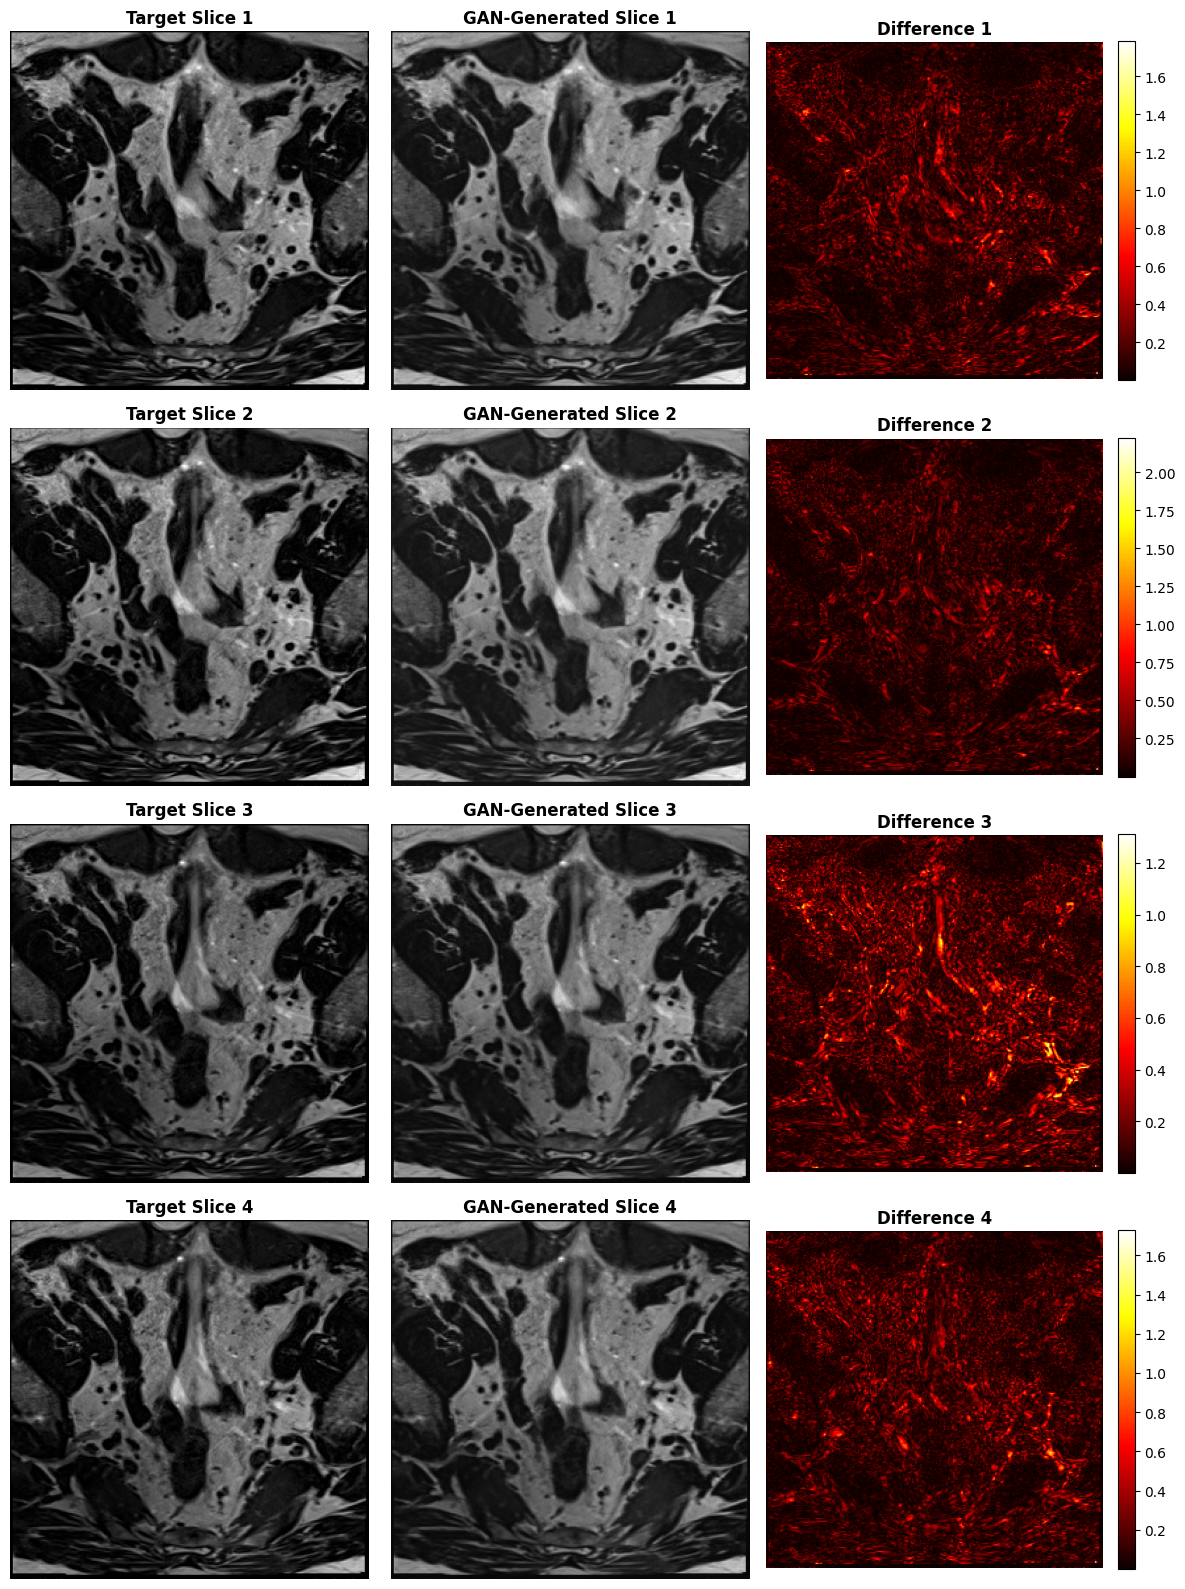

Predictions saved to ../results/unet_gan_predictions.png


In [16]:
# Concatenate all predictions and targets
all_predictions = torch.cat(predictions, dim=0)  # (N, 1, H, W)
all_targets = torch.cat(targets_list, dim=0)      # (N, 1, H, W)

# Visualize some predictions
n_samples = 4
fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))

for i in range(n_samples):
    pred = all_predictions[i, 0].numpy()
    target = all_targets[i, 0].numpy()
    diff = np.abs(pred - target)
    
    axes[i, 0].imshow(target, cmap='gray')
    axes[i, 0].set_title(f'Target Slice {i+1}', fontweight='bold')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(pred, cmap='gray')
    axes[i, 1].set_title(f'GAN-Generated Slice {i+1}', fontweight='bold')
    axes[i, 1].axis('off')
    
    im = axes[i, 2].imshow(diff, cmap='hot')
    axes[i, 2].set_title(f'Difference {i+1}', fontweight='bold')
    axes[i, 2].axis('off')
    plt.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
pred_path = RESULTS_SAVE_DIR / 'unet_gan_predictions.png'
plt.savefig(pred_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Predictions saved to {pred_path}")

# Compute Quality Metrics

In [17]:
# Calculate SSIM and PSNR scores
all_predictions = torch.cat(predictions, dim=0)  # (N, 1, H, W)
all_targets = torch.cat(targets_list, dim=0) 

all_predictions_np = all_predictions.numpy()  # (N, 1, H, W)
all_targets_np = all_targets.numpy()          # (N, 1, H, W)

ssim_scores = []
psnr_scores = []

print("\n" + "="*70)
print("COMPUTING QUALITY METRICS FOR UNet-GAN MODEL")
print("="*70)

for i in range(len(all_predictions_np)):
    pred = all_predictions_np[i, 0]  # (H, W)
    target = all_targets_np[i, 0]     # (H, W)
    
    # Normalize to [0, 1] range for consistent metric calculation
    pred_norm = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
    target_norm = (target - target.min()) / (target.max() - target.min() + 1e-8)
    
    # Calculate SSIM with fixed data_range=1.0
    ssim_score = ssim(target_norm, pred_norm, data_range=1.0)
    ssim_scores.append(ssim_score)
    
    # Calculate PSNR with fixed data_range=1.0
    psnr_score = psnr(target_norm, pred_norm, data_range=1.0)
    psnr_scores.append(psnr_score)

ssim_scores = np.array(ssim_scores)
psnr_scores = np.array(psnr_scores)

print(f"\n📊 UNet-GAN MODEL - IMAGE QUALITY METRICS:")
print(f"\n{'Metric':<20} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12}")
print(f"{'-'*68}")
print(f"{'SSIM':20} {ssim_scores.mean():<12.4f} {ssim_scores.std():<12.4f} {ssim_scores.min():<12.4f} {ssim_scores.max():<12.4f}")
print(f"{'PSNR (dB)':20} {psnr_scores.mean():<12.4f} {psnr_scores.std():<12.4f} {psnr_scores.min():<12.4f} {psnr_scores.max():<12.4f}")

print(f"\n📈 Per-Sample Metrics (first 10 samples):")
for i in range(min(10, len(ssim_scores))):
    print(f"   Sample {i+1:3d}: SSIM = {ssim_scores[i]:.4f}, PSNR = {psnr_scores[i]:.2f} dB")

if len(ssim_scores) > 10:
    print(f"   ... and {len(ssim_scores)-10} more samples")

print("\n" + "="*70)


COMPUTING QUALITY METRICS FOR UNet-GAN MODEL

📊 UNet-GAN MODEL - IMAGE QUALITY METRICS:

Metric               Mean         Std Dev      Min          Max         
--------------------------------------------------------------------
SSIM                 0.7711       0.1238       0.1578       0.9875      
PSNR (dB)            25.6755      4.7587       7.7046       47.3991     

📈 Per-Sample Metrics (first 10 samples):
   Sample   1: SSIM = 0.7849, PSNR = 28.76 dB
   Sample   2: SSIM = 0.8348, PSNR = 30.40 dB
   Sample   3: SSIM = 0.8511, PSNR = 30.19 dB
   Sample   4: SSIM = 0.8572, PSNR = 30.31 dB
   Sample   5: SSIM = 0.8687, PSNR = 31.26 dB
   Sample   6: SSIM = 0.8752, PSNR = 30.98 dB
   Sample   7: SSIM = 0.8683, PSNR = 29.85 dB
   Sample   8: SSIM = 0.8718, PSNR = 29.26 dB
   Sample   9: SSIM = 0.8740, PSNR = 29.57 dB
   Sample  10: SSIM = 0.8723, PSNR = 27.96 dB
   ... and 18230 more samples



# Training History & Summary

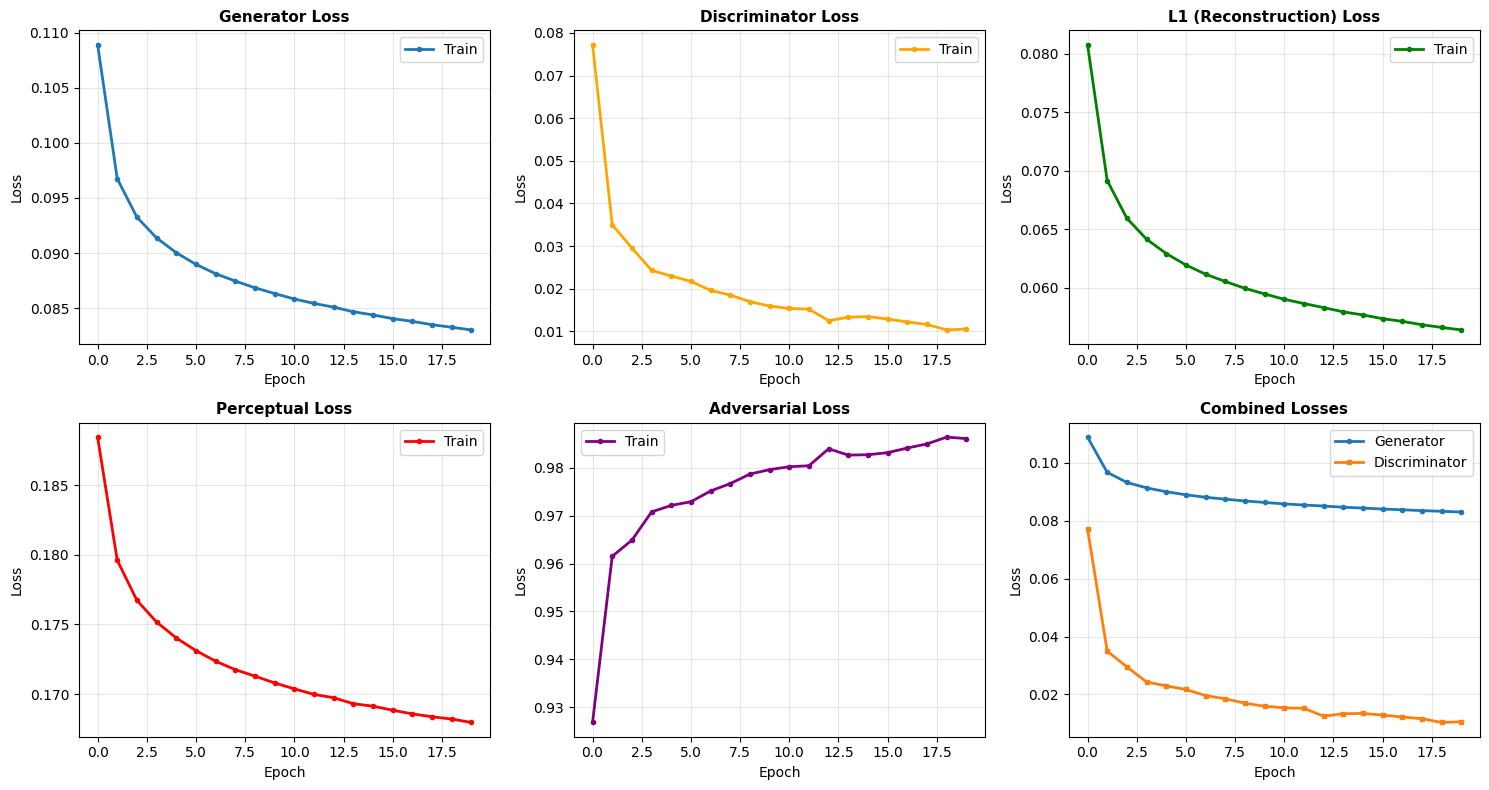

Training curves saved to ../results/unet_gan_training_curves.png


In [18]:
# Plot training curves
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Generator Loss
axes[0, 0].plot(train_losses['g'], label='Train', linewidth=2, marker='o', markersize=3)
axes[0, 0].set_title('Generator Loss', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Discriminator Loss
axes[0, 1].plot(train_losses['d'], label='Train', linewidth=2, marker='o', markersize=3, color='orange')
axes[0, 1].set_title('Discriminator Loss', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# L1 Loss
axes[0, 2].plot(train_losses['l1'], label='Train', linewidth=2, marker='o', markersize=3, color='green')
axes[0, 2].set_title('L1 (Reconstruction) Loss', fontsize=11, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Perceptual Loss
axes[1, 0].plot(train_losses['perc'], label='Train', linewidth=2, marker='o', markersize=3, color='red')
axes[1, 0].set_title('Perceptual Loss', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Adversarial Loss
axes[1, 1].plot(train_losses['adv'], label='Train', linewidth=2, marker='o', markersize=3, color='purple')
axes[1, 1].set_title('Adversarial Loss', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Combined Loss
axes[1, 2].plot(train_losses['g'], label='Generator', linewidth=2, marker='o', markersize=3)
axes[1, 2].plot(train_losses['d'], label='Discriminator', linewidth=2, marker='s', markersize=3)
axes[1, 2].set_title('Combined Losses', fontsize=11, fontweight='bold')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = RESULTS_SAVE_DIR / 'unet_gan_training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curves saved to {plot_path}")

In [19]:
val_losses_saved = checkpoint.get('val_losses', {})
best_val_loss = val_losses_saved.get('g_loss', float('inf'))
best_val_loss

0.09762804546514604

In [20]:
# Save training history
history = {
    'train_losses': train_losses,
    'val_losses': val_losses_saved,
    'test_loss': test_loss,
    'best_val_loss': best_val_loss,
    'epochs_trained': len(train_losses['g']),
    'metrics': {
        'ssim_mean': float(ssim_scores.mean()),
        'ssim_std': float(ssim_scores.std()),
        'psnr_mean': float(psnr_scores.mean()),
        'psnr_std': float(psnr_scores.std())
    },
    'config': {
        'batch_size': BATCH_SIZE,
        'learning_rate_g': LEARNING_RATE_G,
        'learning_rate_d': LEARNING_RATE_D,
        'early_stopping_patience': EARLY_STOPPING_PATIENCE,
        'augmentation': AUGMENT,
        'generator': 'UNet with skip connections',
        'discriminator': 'PatchGAN',
        'gan_type': 'Least Squares GAN (LSGAN)',
        'loss_weights': {
            'lambda_l1': LAMBDA_L1,
            'lambda_perceptual': LAMBDA_PERCEPTUAL,
            'lambda_adversarial': LAMBDA_ADVERSARIAL
        }
    },
    'timestamp': datetime.now().isoformat()
}

log_path = RESULTS_SAVE_DIR / 'unet_gan_history.json'
with open(log_path, 'w') as f:
    json.dump(history, f, indent=4)

print(f"Training history saved to {log_path}")

print(f"\n" + "="*70)
print("UNet-GAN TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\nTraining Summary:")
print(f"   Generator: UNet with skip connections")
print(f"   Discriminator: PatchGAN (patch-based)")
print(f"   GAN Type: Least Squares GAN (LSGAN)")
print(f"   Epochs trained: {len(train_losses['g'])}")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Final test loss: {test_loss:.4f}")
print(f"\nQuality Metrics:")
print(f"   SSIM: {ssim_scores.mean():.4f} ± {ssim_scores.std():.4f}")
print(f"   PSNR: {psnr_scores.mean():.4f} ± {psnr_scores.std():.4f} dB")
print(f"\nLoss Weights:")
print(f"   L1 (Reconstruction): {LAMBDA_L1}")
print(f"   Perceptual: {LAMBDA_PERCEPTUAL}")
print(f"   Adversarial: {LAMBDA_ADVERSARIAL}")
print(f"\nFiles saved to: {MODEL_SAVE_DIR}")
print("="*70)

Training history saved to ../results/unet_gan_history.json

UNet-GAN TRAINING COMPLETED SUCCESSFULLY!

Training Summary:
   Generator: UNet with skip connections
   Discriminator: PatchGAN (patch-based)
   GAN Type: Least Squares GAN (LSGAN)
   Epochs trained: 20
   Best validation loss: 0.0976
   Final test loss: 0.0715

Quality Metrics:
   SSIM: 0.7600 ± 0.1402
   PSNR: 28.5730 ± 4.3795 dB

Loss Weights:
   L1 (Reconstruction): 1.0
   Perceptual: 0.1
   Adversarial: 0.01

Files saved to: ../models
